## Classifiying Documents - SInhala (With StopWord removal)

## 1. Data Profiling
checks and to get an idea of how different features of the data are distributed.

In [321]:
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics
from pandas import DataFrame,Series
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
import matplotlib.pyplot as plt

In [322]:
#Read csv file as a dataframe
df=pd.read_csv("/home/akash/Documents/SLIIT/CDAP/EvaluationJune26/Document Classification Model/testList.csv")

In [323]:
print("The data-set has %d rows and %d columns"%(df.shape[0],df.shape[1]))

The data-set has 2944 rows and 2 columns


## 2. Handling Missing values

In [357]:
df.columns=['content', 'category']

In [358]:
#data-sets usually have missing values in them for a variety of reasons. In Numpy, missing values are represented as NaN and 

from __future__ import print_function #my current version of python doesn't have the functionality that I intend to use in the
#following lines of codes so thus importing fresh and new print function "from the future"
print (df.columns) 

#to calculate number of missing values in each column. True values are coerced as 1 and False as 0 and thus I used that
#fact in "sum" function to calculate how many missing values are there in each column:
print("Missing values")
for col_name in df.columns:
    print (col_name,end=": ")
    print (sum(df[col_name].isnull()))

Index(['content', 'category'], dtype='object')
Missing values
content: 9
category: 0


In [359]:
#Identifi rows that contain null values
print(df.ix[df['content'].isnull()].index)

Int64Index([140, 240, 1088, 1574, 1680, 1701, 1946, 1969, 2038], dtype='int64')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


### We can handle missing value in many ways
1. Either we remove the row which has missing value
2. Or we will "imputate" the missing value
3. Or a more simpler approach: Knowing that the "text_description" column contains text (str) so we can reload the data-set with this knowledge and clearly specifying that in str based missing values. 

In [327]:
#reading the unzipped file here to demonstrate another usage of read_csv function:

df2=pd.read_csv('testList.csv',index_col=False,na_values='',na_filter=True)
df2.columns=['content', 'category']
sum(df2.content.isnull())

9

In [328]:
df2=df2.dropna(subset=['content'])
sum(df2.content.isnull()) #again checking that whether there are still missing values in that column:

0

### Handling duplicate values in the dataframe:

In [334]:
sum(df2.duplicated())

0

In [335]:
# To see which rows are duplicated:
df2.loc[df2.duplicated(keep='first'),]

,content,category


In [336]:
#creating a new dataframe with the duplicate rows removed from the original dataframe. We can also use drop_duplicate(inplace=True)
#parameter as well.
print(df2.shape)
df2=df2.drop_duplicates()

(2933, 2)


In [337]:
#now verifying whether there are still duplicate values in our dataframe or not:
sum(df2.duplicated()) 
df2.shape

(2933, 2)

In [338]:
sum(df2.duplicated())

0

### Finding out the Value Distribution profile of the Category Variable:

In [339]:
#just reassigning somewhat smaller column names for convenience. 
df2.columns=['content', 'category']

In [340]:
category_counter={x:0 for x in set(df2['category'])}

In [341]:
for each_cat in df2['category']:
    category_counter[each_cat]+=1
    
print(category_counter)

{'cricket': 1029, 'football': 853, 'rugby': 1051}


<BarContainer object of 3 artists>

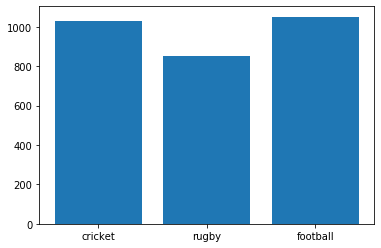

In [342]:
%matplotlib inline
plt.bar(range(len(category_counter)),category_counter.values(),align='center',tick_label=["cricket","rugby","football"])


### Lexical Analysis of the Text Data:
As text data's preprocessing transforms the words/terms into respective columns (though in much improved approach e.g. only frequent terms and also the rare ones (TFIDF) are transformed into columns, more on that later), so its a good step to analyze the vocabulary richness of our data. If we just analyze the lexical richness of the text_description data, it will still give us much idea about how rich our data is in terms of unique vocabulary words:

In [343]:
corpus=df2.content
# corpus.head(10)

In [344]:
#*************************Before this do our pre prosessing**************************

corpus=df2['content'].values.astype('unicode')
#corpus means collection of text. For this particular data-set, I will treat the newly created column title_desc
#as my corpus and will use that to create features.
vectorizer = TfidfVectorizer(stop_words='english')
#Initializing TFIDF vectorizer to conver the raw corpus to a matrix of TFIDF features and also enabling the removal of stopwords.
tfidf_matrix=vectorizer.fit_transform(corpus).todense()
#creating TFIDF features sparse matrix by fitting it on the specified corpus. 
tfidf_names=vectorizer.get_feature_names()
#grabbing the name of the features.

In [345]:
print("Number of TFIDF Features: %d"%len(tfidf_names)) #same info can be gathered by using tfidf_matrix.shape

Number of TFIDF Features: 5858


In [346]:
#which shows that there are 5816 columns that will be used for training the classifier. These are much smaller than the total
#number of unique vocabulary words that are there (as we calculated previously) in the text description column alone.

In [347]:
training_time_container={'b_naive_bayes':0,'mn_naive_bayes':0,'random_forest':0,'linear_svm':0}
prediction_time_container={'b_naive_bayes':0,'mn_naive_bayes':0,'random_forest':0,'linear_svm':0}

accuracy_container={'b_naive_bayes':0,'mn_naive_bayes':0,'random_forest':0,'linear_svm':0}

### Learning Classifiers, Making Predictions and Validating Results
With the data preprocessed, now is the time to develop the models. When it comes to developing machine learning models (and in our particular case, classifiers), we need to firstly train them on the labeled training data to learn from and then use the test data-set to make predictions. So to do that, we will proceed with splitting our existing data-set into training and test data as follows:

In [348]:
# As no separate test data-set was given so the provided data set is split into training and test data set using 70-30% ratio 
#as follows:
variables = tfidf_matrix
#considering the TFIDF features as independent variables to be input to the classifier.
labels = df2.category
#considering the category values as the class labels for the classifier.

variables_train, variables_test, labels_train, labels_test  =   train_test_split(variables, labels, test_size=.3, random_state = 22)
#splitting the data into random training and test sets for both independent variables and labels.

In [349]:
#analyzing the shape of the training and test data-set:
print('Shape of Training Data: '+str(variables_train.shape))
print('Shape of Test Data: '+str(variables_test.shape))

Shape of Training Data: (2053, 5858)
Shape of Test Data: (880, 5858)


### Applying Naive Bayes:
Naive Bayes is one of the most widely used classification algorithm in text mining applications. Based on Bayes theorem, this model makes the assumption that all the features are independent of each other and uses the probabilities of each attribute belonging to each class to make a prediction. 
The condition of independence may not be valid in many circumstances but as a base line model, its a good starting point to test its performance on the provided data. There are two forms of Naive Bayes:

Bernoulli (designed for boolean/binary features i.e. just considers the presence or absense of a feature)
Multinomial (which also considers the occurrence counts of the feature)
We will apply both and then will assess their respective accuracy scores:

In [350]:
training_time_container.keys()

dict_keys(['b_naive_bayes', 'mn_naive_bayes', 'random_forest', 'linear_svm'])

In [351]:
from sklearn.naive_bayes import BernoulliNB
#loading Gaussian Naive Bayes from the sklearn library:
bnb_classifier=BernoulliNB()
#initializing the object
t0=time()
bnb_classifier=bnb_classifier.fit(variables_train,labels_train)
training_time_container['b_naive_bayes']=time()-t0
#fitting the classifier or training the classifier on the training data

In [352]:
#after the model has been trained, we proceed to test its performance on the test data:
t0=time()
bnb_predictions=bnb_classifier.predict(variables_test)
prediction_time_container['b_naive_bayes']=time()-t0

In [353]:
prediction_time_container['b_naive_bayes']

0.08928751945495605

In [354]:
#the trained classifier has been used to make predictions on the test data-set. To evaluate the performance of the model,
#there are a number of metrics that can be used as follows:
nb_ascore=sklearn.metrics.accuracy_score(labels_test, bnb_predictions)
accuracy_container['b_naive_bayes']=nb_ascore

In [355]:
print("Bernoulli Naive Bayes Accuracy Score: %f"%accuracy_container['b_naive_bayes'])
print("Training Time: %f"%training_time_container['b_naive_bayes'])
print("Prediction Time: %f"%prediction_time_container['b_naive_bayes'])

Bernoulli Naive Bayes Accuracy Score: 0.895455
Training Time: 0.229311
Prediction Time: 0.089288


In [356]:
#it shows that the accuracy score of our model is 0.954 or 95.4%. 
#Confusion Matrix is also another way to evaluate the prediction output of a classifier and also to determine the false positive
#and false negative, sensitivity, specificity, precision and recall metrics:
print("Confusion Matrix of Bernoulli Naive Bayes Classifier output: ")
sklearn.metrics.confusion_matrix(labels_test,bnb_predictions)
#the values on the diagonal show correct predictions where as off-diagonal represent the records that have been misclassified.
#also printing the detailed report as follows:

Confusion Matrix of Bernoulli Naive Bayes Classifier output: 


array([[260,  45,   3],
       [  1, 249,   6],
       [  1,  36, 279]])

In [308]:
# [200,  45,   8],
#        [  0, 239,  18],
#        [  3,  52, 272]])
    
# 0.875870

### Applying Multinomial Naive Bayes
Multinomial (which also considers the occurrence counts of the feature) ( TF-IDF )     
-----------------Bernoulli Naive Bayes just uses the fact that whether a feature is present or not. 

In [317]:
from sklearn.naive_bayes import MultinomialNB
mn_bayes=MultinomialNB()
t0=time()
mn_bayes_fit=mn_bayes.fit(variables_train,labels_train)
training_time_container['mn_naive_bayes']=time()-t0
t0=time()
prediction_mn=mn_bayes_fit.predict(variables_test)
prediction_time_container['mn_naive_bayes']=time()-t0
mn_ascore=sklearn.metrics.accuracy_score(labels_test, prediction_mn) 
accuracy_container['mn_naive_bayes']=mn_ascore

In [318]:
#if we see the accuracy score of Multinomial Naive Bayes classifier, we come to see that it turns out be around 0.934 or 93.4%
print("Accuracy Score of Multi-Nomial Naive Bayes: %f" %(mn_ascore))
#and its training and prediction time are:
print("Training Time: %fs"%training_time_container['mn_naive_bayes'])
print("Prediction Time: %fs"%prediction_time_container['mn_naive_bayes'])

Accuracy Score of Multi-Nomial Naive Bayes: 0.896591
Training Time: 0.100897s
Prediction Time: 0.026283s


### Applying Random Forest Classifier

In [319]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier=RandomForestClassifier(n_estimators=50)
t0=time()
rf_classifier=rf_classifier.fit(variables_train,labels_train)

training_time_container['random_forest']=time()-t0
print("Training Time: %fs"%training_time_container['random_forest'])

t0=time()
rf_predictions=rf_classifier.predict(variables_test)
prediction_time_container['random_forest']=time()-t0
print("Prediction Time: %fs"%prediction_time_container['random_forest'])

accuracy_container['random_forest']=sklearn.metrics.accuracy_score(labels_test, rf_predictions)
print ("Accuracy Score of Random Forests Classifier: ")
print(accuracy_container['random_forest'])
print(sklearn.metrics.confusion_matrix(labels_test,rf_predictions))

Training Time: 1.733319s
Prediction Time: 0.040318s
Accuracy Score of Random Forests Classifier: 
0.9386363636363636
[[292  10   6]
 [  1 237  18]
 [  1  18 297]]


### Applying Linear Classifier (SVM) using Stochastic Gradient Descent

In [320]:
#I've used hinge loss which gives linear Support Vector Machine. Also set the learning rate to 0.0001 (also the default value)
#which is a constant that's gets multiplied with the regularization term. For penalty, I've used L2 which is the standard
#regularizer for linear SVMs:

from sklearn import linear_model

svm_classifier=linear_model.SGDClassifier(loss='hinge',alpha=0.0001)

t0=time()
svm_classifier=svm_classifier.fit(variables_train, labels_train)
training_time_container['linear_svm']=time()-t0
print("Training Time: %fs"%training_time_container['linear_svm'])

t0=time()
svm_predictions=svm_classifier.predict(variables_test)
prediction_time_container['linear_svm']=time()-t0
print("Prediction Time: %fs"%prediction_time_container['linear_svm'])

accuracy_container['linear_svm']=sklearn.metrics.accuracy_score(labels_test, svm_predictions)
print ("Accuracy Score of Linear SVM Classifier: %f"%accuracy_container['linear_svm'])
print(sklearn.metrics.confusion_matrix(labels_test,svm_predictions))


Training Time: 1.550902s
Prediction Time: 0.012605s
Accuracy Score of Linear SVM Classifier: 0.956818
[[307   1   0]
 [  1 235  20]
 [  2  14 300]]


In [37]:
svm_classifier_enet=linear_model.SGDClassifier(loss='hinge',alpha=0.0001,penalty='elasticnet')
svm_classifier_enet=svm_classifier_enet.fit(variables_train, labels_train)

In [38]:
svm_enet_predictions=svm_classifier_enet.predict(variables_test)

In [806]:
print ("Accuracy Score of Linear SVM Classifier: %f"%sklearn.metrics.accuracy_score(labels_test,svm_enet_predictions))
# we saw marginal improvement in the overall accuracy score.

Accuracy Score of Linear SVM Classifier: 0.943182


In [808]:
%matplotlib inline
import matplotlib.pyplot as plt

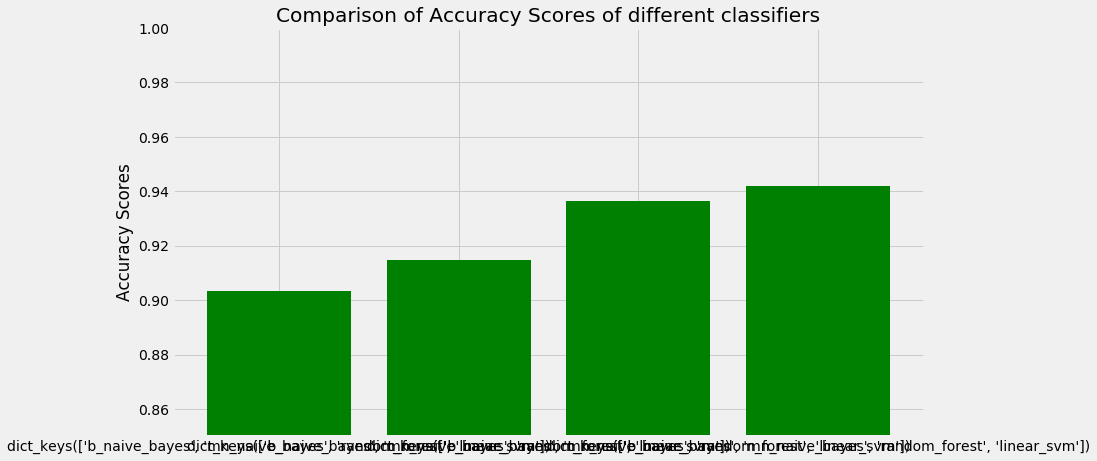

In [811]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,7))
    plt.bar(range(4),accuracy_container.values(),tick_label=accuracy_container.keys(),align='center',color='g')
    
    plt.ylabel("Accuracy Scores")
    plt.grid(True)
    plt.title("Comparison of Accuracy Scores of different classifiers")
    plt.ylim(0.85,1.0)